### Model training

This notebook provides a minimal example to train the model with a 2D latent space, and shows the resulting representations with only a small number of training steps. 
 - `model.py` contains the architecture and loss function 
 - `train.py` includes the training procedure used in the manuscript.

In [1]:
import sys
from pathlib import Path
#Add path to parent folder for imports
sys.path.append(str(Path.cwd().parent))

In [2]:
import tensorflow as tf
from utils.dataset import load_bioarxiv_dataset,partitions, Datagen
from model import Model_TE_aug_decoders, custom_build

#### 1. Dataset and network initialization

**Note:** The E data contains a small number of `nan` values, which are masked by the network during training. For inference, it is best to zero out the `nan` values since the network is robust to dropout of features. 

In [3]:
n_partitions=40
cvfold=0

D = load_bioarxiv_dataset('../data/proc/')
XT = D['T_dat']
XE = D['E_pcipfx']
ind_dict = partitions(D['cluster'], n_partitions=40, seed=0)
train_ind,val_ind = ind_dict[cvfold]['train'],ind_dict[cvfold]['val']

T_dim = XT.shape[1]
E_dim = XE.shape[1]

In [4]:
batchsize = 200
n_epochs = 10
n_steps_per_epoch = 500
maxsteps = n_epochs*n_steps_per_epoch

#Load and build model, with training and augmentation mode enabled
cplAE = Model_TE_aug_decoders(T_dim,E_dim,latent_dim=2,
                              train_T=True, 
                              train_E=True,
                              augment_decoders=True)

cplAE = custom_build(cplAE,(T_dim,E_dim))

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
train_generator = tf.data.Dataset.from_generator(Datagen,output_types=(tf.float32, tf.float32),
                                                 args=(maxsteps,batchsize,XT[train_ind,:],XE[train_ind,:]))

#### 2. Training step and reporting metrics

In [5]:
#Training step
@tf.function
def train_fn(model, optimizer, xt, xe):
    with tf.GradientTape() as tape:
        zT, zE, XrT, XrE = model((xt, xe))

        trainable_weights = [weight for weight in model.trainable_weights]
        loss = sum(model.losses)

    grads = tape.gradient(loss, trainable_weights)
    optimizer.apply_gradients(zip(grads, trainable_weights))
    return zT, zE, XrT, XrE 

In [6]:
#Print losses calculated. These are MSE calculations that do not include the  
def report_metrics(model, epoch, losstype):
    print('{:10s} Epoch:{:05d}, '
            'mse_T: {:0.3f}, '
            'mse_E: {:0.3f}, '
            'mse_TE: {:0.3f}'.format(losstype,epoch,
                                    model.mse_loss_T.numpy(),
                                    model.mse_loss_E.numpy(),
                                    model.mse_loss_TE.numpy()))

#### 3. Train the network for a few steps

In [7]:
epoch=0
for step, (xT,xE) in enumerate(train_generator):
    train_fn(model=cplAE,optimizer=adam_optimizer,xt=xT,xe=xE)
    
    #Report training loss
    if (step+1) % n_steps_per_epoch == 0:
        #Set to validation mode:
        cplAE.train_T=False
        cplAE.train_E=False

        #Report metrics on training set
        cplAE((tf.constant(XT[train_ind,:],dtype=tf.float32), tf.constant(XE[train_ind,:],dtype=tf.float32)))
        report_metrics(model=cplAE ,epoch=epoch, losstype='Train')
            
        #Report metrics on validation set
        cplAE((tf.constant(XT[val_ind,:],dtype=tf.float32), tf.constant(XE[val_ind,:],dtype=tf.float32)))
        report_metrics(model=cplAE ,epoch=epoch, losstype='Validation')
                
        #Set network to training mode
        cplAE.train_T=True
        cplAE.train_E=True
        
        #Update epoch count
        epoch=epoch+1

Train      Epoch:00000, mse_T: 3.133, mse_E: 0.755, mse_TE: 0.116
Validation Epoch:00000, mse_T: 3.117, mse_E: 0.825, mse_TE: 0.176
Train      Epoch:00001, mse_T: 3.047, mse_E: 0.699, mse_TE: 0.063
Validation Epoch:00001, mse_T: 3.048, mse_E: 0.779, mse_TE: 0.113
Train      Epoch:00002, mse_T: 2.982, mse_E: 0.680, mse_TE: 0.052
Validation Epoch:00002, mse_T: 2.985, mse_E: 0.763, mse_TE: 0.098
Train      Epoch:00003, mse_T: 2.933, mse_E: 0.669, mse_TE: 0.044
Validation Epoch:00003, mse_T: 2.944, mse_E: 0.751, mse_TE: 0.093
Train      Epoch:00004, mse_T: 2.861, mse_E: 0.649, mse_TE: 0.033
Validation Epoch:00004, mse_T: 2.874, mse_E: 0.727, mse_TE: 0.074
Train      Epoch:00005, mse_T: 2.738, mse_E: 0.637, mse_TE: 0.040
Validation Epoch:00005, mse_T: 2.747, mse_E: 0.711, mse_TE: 0.089
Train      Epoch:00006, mse_T: 2.678, mse_E: 0.622, mse_TE: 0.035
Validation Epoch:00006, mse_T: 2.685, mse_E: 0.697, mse_TE: 0.073
Train      Epoch:00007, mse_T: 2.672, mse_E: 0.630, mse_TE: 0.031
Validation

In [8]:
cplAE.train_T=False
cplAE.train_E=False
zT,zE,XrT,XrE = cplAE((tf.constant(XT,dtype=tf.float32), tf.constant(XE,dtype=tf.float32)))

In [9]:
zT = zT.numpy()
zE = zE.numpy()

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
%matplotlib inline

#### 4. Visualize the 2d representations

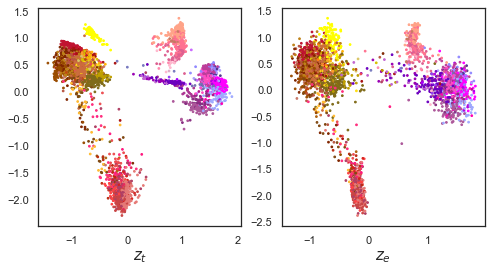

In [11]:
#Plot representations
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.scatter(zT[:,0],zT[:,1],s=3,c=D['cluster_color'])
ax = plt.gca()
ax.set_xlabel(r'$z_t$',fontsize=15)

plt.subplot(1,2,2)
plt.scatter(zE[:,0],zE[:,1],s=3,c=D['cluster_color'])
ax = plt.gca()
ax.set_xlabel(r'$z_e$',fontsize=15)

plt.show()